# Full Image to Path Pipeline for Hypertrophic Laser Scar Therapy

## Installations and Configuring global variables

In [ ]:
# %pip install -q segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 8.1 MB/s eta 0:00:00


In [2]:
import os
import torch
import numpy as np
import cv2
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from scipy.ndimage import rotate
from matplotlib.artist import get
import imageio
from PIL import Image
import shutil

# CONFIG
DATA_DIR = "Segmentation"
CLASSES = ["background", "skin", "scar"]
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 5
EPOCHS = 50
LR = 1e-4
IMAGE_SIZE = 256
NUM_CLASSES = len(CLASSES)
LASER_SIZE = 24
LASER_INDIVIDUAL_SIZE = 8
LASER_TEMP = 500;
SCAR_THICK = 8e-3;

## Segmentation U-Net Fine-tuning

### Dataset Class and Augmentation

In [3]:
class SegPngDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        """
        Args:
            data_dir (str): Directory containing images and masks.
            transform (callable, optional): Optional transform to be applied
                on an image and its mask.
        """
        self.data_dir = data_dir
        self.transform = transform
        # Only pick the images (does not contain _mask)
        self.images = sorted([f for f in os.listdir(data_dir) if (not f.endswith("_mask.png") and f.endswith(".png"))])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Load image
        img_name = self.images[idx]
        img_path = os.path.join(self.data_dir, img_name)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Load corresponding mask
        mask_name = img_name.replace(".png", "_mask.png")
        mask_path = os.path.join(self.data_dir, mask_name)
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)  # Keep original values 0,1,2
        mask = mask.astype(np.uint8)

        # Ensure mask shape matches image
        if mask.shape != image.shape[:2]:
            mask = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

        # Apply transforms if provided
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]
            image = image.float()
            mask = mask.long()

        return image, mask

In [4]:
# AUGMENTATION
train_transform = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    ToTensorV2(),
])

# DATA SPLIT
dataset = SegPngDataset(DATA_DIR, transform=train_transform)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)

### Model Definition and Training

In [5]:
# MODEL
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet", # pretrained ResNet34 encoder
    in_channels=3,
    classes=NUM_CLASSES,
    ).to(DEVICE)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

In [6]:
# LOSS & OPTIMIZER
dice_loss = smp.losses.DiceLoss(mode='multiclass')
ce_loss   = smp.losses.SoftCrossEntropyLoss(smooth_factor=0.1)
def loss_fn(pred, target):
    return dice_loss(pred, target) + ce_loss(pred, target)

def pixel_accuracy(preds, masks):
    # determine in-image segmentation accuracy
    preds = torch.argmax(preds, dim=1)  # [B, H, W]
    correct = (preds == masks).float()
    return correct.mean()

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

best_loss = float('inf')
best_acc = 0

# TRAINING
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        preds = model(imgs)
        loss = loss_fn(preds, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # VALIDATION
    model.eval()
    val_loss = 0
    val_acc = 0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
            preds = model(imgs)
            val_loss += loss_fn(preds, masks).item()
            val_acc += pixel_accuracy(preds, masks).item()
    print(f"Epoch [{epoch+1}/{EPOCHS}], "
          f"Train Loss: {train_loss/len(train_loader):.4f}, "
          f"Val Loss: {val_loss/len(val_loader):.4f}, "
          f"Val Acc: {val_acc/len(val_loader)*100:.2f}")

    if val_loss < best_loss:
        best_loss = val_loss
        best_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print("Saved Best Model!")

Epoch 1/50: 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]


Epoch [1/50], Train Loss: 1.8968, Val Loss: 1.6597, Val Acc: 69.40
Saved Best Model!


Epoch 2/50: 100%|██████████| 3/3 [00:00<00:00,  7.57it/s]


Epoch [2/50], Train Loss: 1.7326, Val Loss: 1.7543, Val Acc: 41.54


Epoch 3/50: 100%|██████████| 3/3 [00:00<00:00,  8.43it/s]


Epoch [3/50], Train Loss: 1.6051, Val Loss: 1.7871, Val Acc: 34.78


Epoch 4/50: 100%|██████████| 3/3 [00:00<00:00,  8.45it/s]


Epoch [4/50], Train Loss: 1.5300, Val Loss: 1.7858, Val Acc: 35.03


Epoch 5/50: 100%|██████████| 3/3 [00:00<00:00,  8.55it/s]


Epoch [5/50], Train Loss: 1.4254, Val Loss: 1.7606, Val Acc: 35.74


Epoch 6/50: 100%|██████████| 3/3 [00:00<00:00,  8.38it/s]


Epoch [6/50], Train Loss: 1.3186, Val Loss: 1.7147, Val Acc: 43.95


Epoch 7/50: 100%|██████████| 3/3 [00:00<00:00,  8.45it/s]


Epoch [7/50], Train Loss: 1.2464, Val Loss: 1.5840, Val Acc: 51.08
Saved Best Model!


Epoch 8/50: 100%|██████████| 3/3 [00:00<00:00,  8.47it/s]


Epoch [8/50], Train Loss: 1.1754, Val Loss: 1.5181, Val Acc: 54.92
Saved Best Model!


Epoch 9/50: 100%|██████████| 3/3 [00:00<00:00,  8.41it/s]


Epoch [9/50], Train Loss: 1.1069, Val Loss: 1.4718, Val Acc: 62.35
Saved Best Model!


Epoch 10/50: 100%|██████████| 3/3 [00:00<00:00,  7.17it/s]


Epoch [10/50], Train Loss: 1.0681, Val Loss: 1.3976, Val Acc: 69.48
Saved Best Model!


Epoch 11/50: 100%|██████████| 3/3 [00:00<00:00,  7.05it/s]


Epoch [11/50], Train Loss: 1.0098, Val Loss: 1.4173, Val Acc: 67.85


Epoch 12/50: 100%|██████████| 3/3 [00:00<00:00,  6.81it/s]


Epoch [12/50], Train Loss: 0.9589, Val Loss: 1.3601, Val Acc: 72.32
Saved Best Model!


Epoch 13/50: 100%|██████████| 3/3 [00:00<00:00,  8.11it/s]


Epoch [13/50], Train Loss: 0.9123, Val Loss: 1.3377, Val Acc: 73.32
Saved Best Model!


Epoch 14/50: 100%|██████████| 3/3 [00:00<00:00,  8.44it/s]


Epoch [14/50], Train Loss: 0.9414, Val Loss: 1.2715, Val Acc: 78.06
Saved Best Model!


Epoch 15/50: 100%|██████████| 3/3 [00:00<00:00,  8.44it/s]


Epoch [15/50], Train Loss: 0.8785, Val Loss: 1.2859, Val Acc: 76.22


Epoch 16/50: 100%|██████████| 3/3 [00:00<00:00,  8.38it/s]


Epoch [16/50], Train Loss: 0.8478, Val Loss: 1.2173, Val Acc: 80.08
Saved Best Model!


Epoch 17/50: 100%|██████████| 3/3 [00:00<00:00,  8.01it/s]


Epoch [17/50], Train Loss: 0.8159, Val Loss: 1.2447, Val Acc: 77.83


Epoch 18/50: 100%|██████████| 3/3 [00:00<00:00,  8.39it/s]


Epoch [18/50], Train Loss: 0.8424, Val Loss: 1.1371, Val Acc: 81.14
Saved Best Model!


Epoch 19/50: 100%|██████████| 3/3 [00:00<00:00,  8.56it/s]


Epoch [19/50], Train Loss: 0.7896, Val Loss: 1.1261, Val Acc: 81.27
Saved Best Model!


Epoch 20/50: 100%|██████████| 3/3 [00:00<00:00,  8.50it/s]


Epoch [20/50], Train Loss: 0.7324, Val Loss: 1.1195, Val Acc: 81.31
Saved Best Model!


Epoch 21/50: 100%|██████████| 3/3 [00:00<00:00,  8.08it/s]


Epoch [21/50], Train Loss: 0.7645, Val Loss: 1.0560, Val Acc: 84.16
Saved Best Model!


Epoch 22/50: 100%|██████████| 3/3 [00:00<00:00,  8.39it/s]


Epoch [22/50], Train Loss: 0.7276, Val Loss: 0.9876, Val Acc: 87.95
Saved Best Model!


Epoch 23/50: 100%|██████████| 3/3 [00:00<00:00,  8.60it/s]


Epoch [23/50], Train Loss: 0.7264, Val Loss: 1.0033, Val Acc: 86.74


Epoch 24/50: 100%|██████████| 3/3 [00:00<00:00,  8.57it/s]


Epoch [24/50], Train Loss: 0.7212, Val Loss: 1.0380, Val Acc: 85.36


Epoch 25/50: 100%|██████████| 3/3 [00:00<00:00,  8.56it/s]


Epoch [25/50], Train Loss: 0.7260, Val Loss: 1.0220, Val Acc: 84.54


Epoch 26/50: 100%|██████████| 3/3 [00:00<00:00,  8.59it/s]


Epoch [26/50], Train Loss: 0.7276, Val Loss: 1.0346, Val Acc: 83.75


Epoch 27/50: 100%|██████████| 3/3 [00:00<00:00,  8.38it/s]


Epoch [27/50], Train Loss: 0.6783, Val Loss: 1.0084, Val Acc: 83.33


Epoch 28/50: 100%|██████████| 3/3 [00:00<00:00,  8.54it/s]


Epoch [28/50], Train Loss: 0.7624, Val Loss: 1.0022, Val Acc: 84.25


Epoch 29/50: 100%|██████████| 3/3 [00:00<00:00,  8.60it/s]


Epoch [29/50], Train Loss: 0.6314, Val Loss: 0.9696, Val Acc: 85.83
Saved Best Model!


Epoch 30/50: 100%|██████████| 3/3 [00:00<00:00,  8.68it/s]


Epoch [30/50], Train Loss: 0.6230, Val Loss: 0.9492, Val Acc: 86.15
Saved Best Model!


Epoch 31/50: 100%|██████████| 3/3 [00:00<00:00,  8.41it/s]


Epoch [31/50], Train Loss: 0.6744, Val Loss: 0.9758, Val Acc: 85.51


Epoch 32/50: 100%|██████████| 3/3 [00:00<00:00,  8.57it/s]


Epoch [32/50], Train Loss: 0.6082, Val Loss: 0.9710, Val Acc: 85.15


Epoch 33/50: 100%|██████████| 3/3 [00:00<00:00,  7.24it/s]


Epoch [33/50], Train Loss: 0.6006, Val Loss: 0.9245, Val Acc: 86.46
Saved Best Model!


Epoch 34/50: 100%|██████████| 3/3 [00:00<00:00,  7.20it/s]


Epoch [34/50], Train Loss: 0.6413, Val Loss: 0.9239, Val Acc: 86.39
Saved Best Model!


Epoch 35/50: 100%|██████████| 3/3 [00:00<00:00,  7.17it/s]


Epoch [35/50], Train Loss: 0.5876, Val Loss: 0.9214, Val Acc: 86.44
Saved Best Model!


Epoch 36/50: 100%|██████████| 3/3 [00:00<00:00,  6.90it/s]


Epoch [36/50], Train Loss: 0.6271, Val Loss: 0.9367, Val Acc: 86.29


Epoch 37/50: 100%|██████████| 3/3 [00:00<00:00,  8.48it/s]


Epoch [37/50], Train Loss: 0.6119, Val Loss: 0.9446, Val Acc: 85.78


Epoch 38/50: 100%|██████████| 3/3 [00:00<00:00,  8.50it/s]


Epoch [38/50], Train Loss: 0.6101, Val Loss: 0.9781, Val Acc: 84.15


Epoch 39/50: 100%|██████████| 3/3 [00:00<00:00,  8.51it/s]


Epoch [39/50], Train Loss: 0.5950, Val Loss: 0.9466, Val Acc: 86.20


Epoch 40/50: 100%|██████████| 3/3 [00:00<00:00,  8.63it/s]


Epoch [40/50], Train Loss: 0.6043, Val Loss: 0.9166, Val Acc: 86.36
Saved Best Model!


Epoch 41/50: 100%|██████████| 3/3 [00:00<00:00,  8.50it/s]


Epoch [41/50], Train Loss: 0.5488, Val Loss: 0.9769, Val Acc: 84.09


Epoch 42/50: 100%|██████████| 3/3 [00:00<00:00,  8.57it/s]


Epoch [42/50], Train Loss: 0.5628, Val Loss: 0.9800, Val Acc: 84.61


Epoch 43/50: 100%|██████████| 3/3 [00:00<00:00,  8.49it/s]


Epoch [43/50], Train Loss: 0.6389, Val Loss: 0.9243, Val Acc: 85.78


Epoch 44/50: 100%|██████████| 3/3 [00:00<00:00,  8.63it/s]


Epoch [44/50], Train Loss: 0.6101, Val Loss: 0.9505, Val Acc: 85.05


Epoch 45/50: 100%|██████████| 3/3 [00:00<00:00,  8.61it/s]


Epoch [45/50], Train Loss: 0.5574, Val Loss: 0.8763, Val Acc: 88.07
Saved Best Model!


Epoch 46/50: 100%|██████████| 3/3 [00:00<00:00,  8.18it/s]


Epoch [46/50], Train Loss: 0.5700, Val Loss: 0.9264, Val Acc: 86.23


Epoch 47/50: 100%|██████████| 3/3 [00:00<00:00,  8.31it/s]


Epoch [47/50], Train Loss: 0.5587, Val Loss: 0.9867, Val Acc: 83.07


Epoch 48/50: 100%|██████████| 3/3 [00:00<00:00,  8.43it/s]


Epoch [48/50], Train Loss: 0.5650, Val Loss: 0.9343, Val Acc: 84.27


Epoch 49/50: 100%|██████████| 3/3 [00:00<00:00,  8.21it/s]


Epoch [49/50], Train Loss: 0.5438, Val Loss: 0.9317, Val Acc: 85.07


Epoch 50/50: 100%|██████████| 3/3 [00:00<00:00,  8.47it/s]

Epoch [50/50], Train Loss: 0.5739, Val Loss: 0.8958, Val Acc: 86.45


In [7]:
#load the best model
with torch.no_grad():
    model.load_state_dict(torch.load("best_model.pth"))
model.eval()
print(f"Best Loss: {best_loss/len(val_loader):.4f}, Best Acc: {best_acc/len(val_loader)*100:.2f}")

Best Loss: 0.8763, Best Acc: 88.07


### Visualizing Segmentation Effectiveness

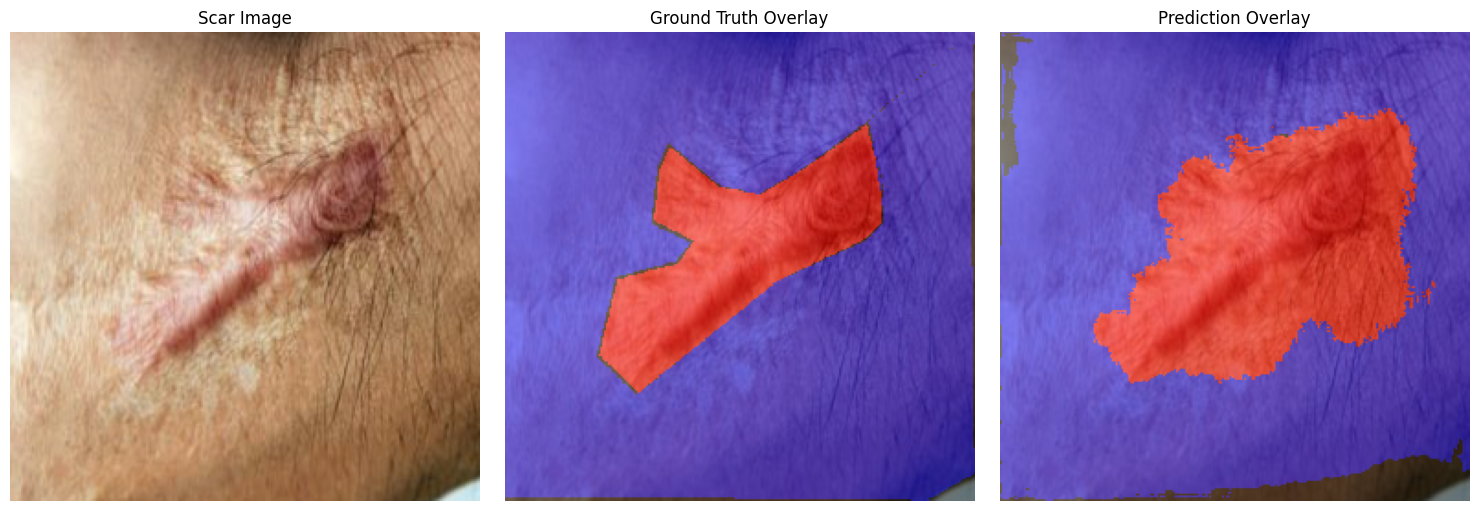

In [8]:
#visualize accuracy
COLORS = np.array([
    [0, 0, 0],        # background
    [0, 0, 255],      # Skin
    [255, 0, 0],      # Scar
], dtype=np.uint8)

def mask_to_rgb(mask, colors=COLORS):
    h, w = mask.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for cls in range(len(colors)):
        rgb[mask == cls] = colors[cls]
    return rgb

def overlay(image, mask_rgb, alpha=0.5):
    return (image * (1 - alpha) + mask_rgb / 255.0 * alpha)

def visualize_prediction(model, dataloader, device):
    model.eval()

    imgs, masks = next(iter(dataloader))
    imgs, masks = imgs.to(device), masks.to(device)

    with torch.no_grad():
        preds = model(imgs)
        preds = torch.argmax(preds, dim=1)

    # Pick one sample
    idx = np.random.randint(0,len(imgs))
    img  = imgs[idx].cpu()
    mask = masks[idx].cpu().numpy()
    pred = preds[idx].cpu().numpy()

    # Convert image to HWC
    img = img.permute(1, 2, 0).numpy()

    # Normalize image for display if needed
    img = (img - img.min()) / (img.max() - img.min() + 1e-6)

    mask_rgb = mask_to_rgb(mask)
    pred_rgb = mask_to_rgb(pred)

    # Plot
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Scar Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(overlay(img, mask_rgb))
    plt.title("Ground Truth Overlay")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(overlay(img, pred_rgb))
    plt.title("Prediction Overlay")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

visualize_prediction(model, val_loader, DEVICE)


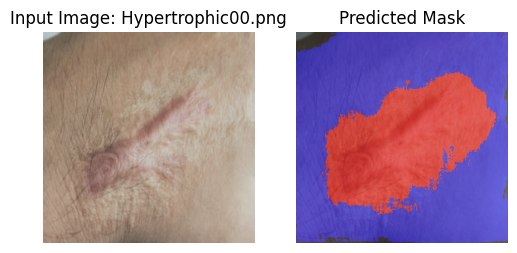

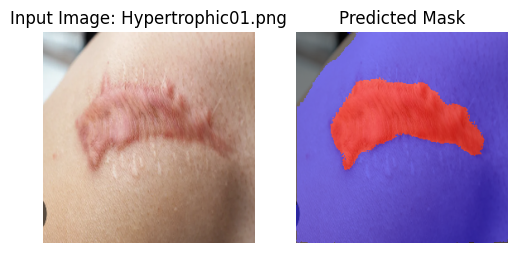

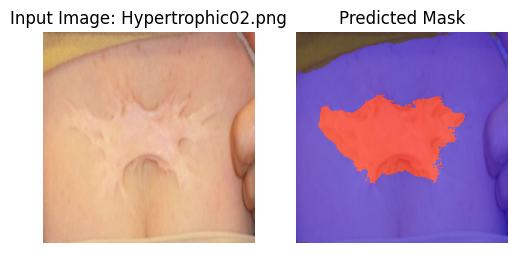

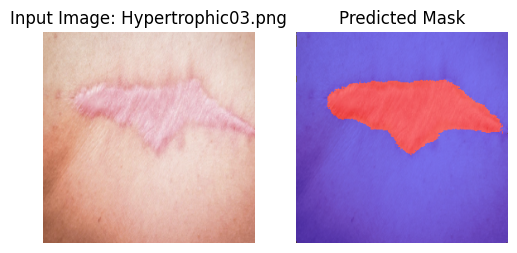

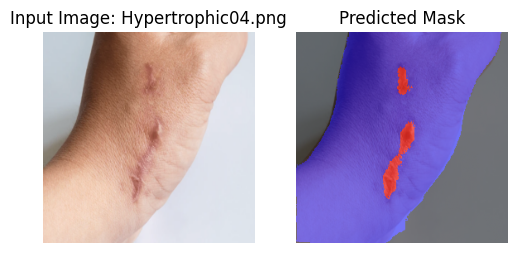

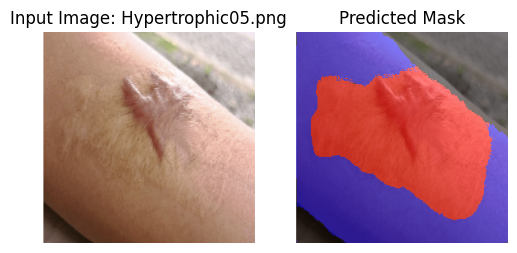

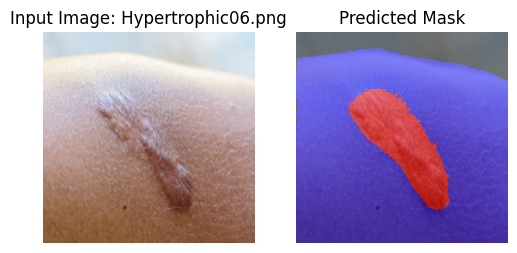

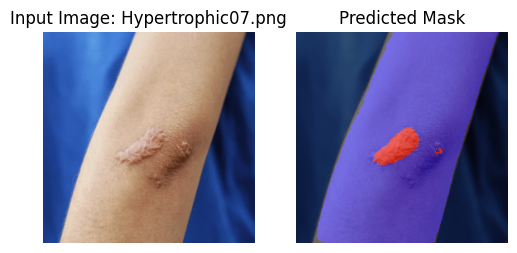

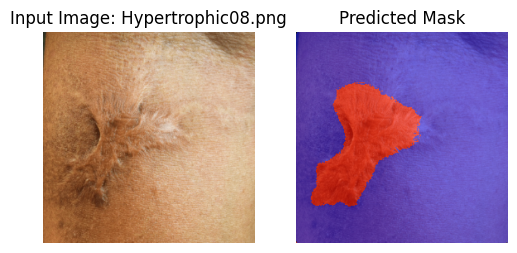

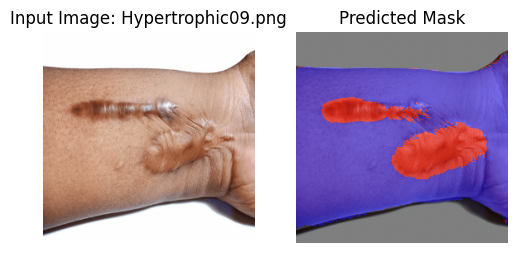

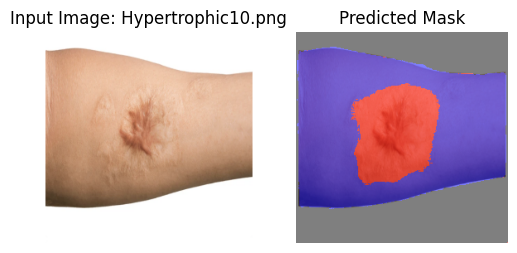

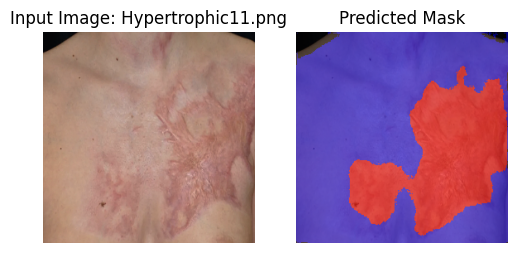

In [9]:
image_dir = "/content/Images"
image_names = [f"Hypertrophic{str(i).zfill(2)}.png" for i in range(12)]  # 00 to 11

# --- Inference & Visualization ---
with torch.no_grad():
    for img_name in image_names:
        image_path = os.path.join(image_dir, img_name)

        # Load and preprocess image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_resized = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))

        # Apply validation transform
        input_tensor = val_transform(image=image_resized)["image"].unsqueeze(0).to(DEVICE)
        input_tensor = input_tensor.float()

        # Model prediction
        preds = model(input_tensor)
        pred_mask = torch.argmax(preds, dim=1)

        # Visualization
        plt.figure(figsize=(6,3))
        plt.subplot(1,2,1)
        plt.title(f"Input Image: {img_name}")
        plt.imshow(image_resized)
        plt.axis("off")

        plt.subplot(1,2,2)
        plt.title("Predicted Mask")
        plt.imshow(overlay(image_resized/255.0, mask_to_rgb(pred_mask.squeeze(0).cpu().numpy())))
        plt.axis("off")

        plt.show()


## Post-Processing of Segmentation Mask

### Removing Small Noise + Adding Gaussian Blur

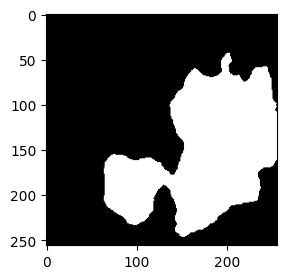

In [10]:
# isolating the scar mask
def isolate_scar_mask(pred_mask):
    # Create a binary mask for the scar (scar = 2)
    scar_mask = (pred_mask == 2).astype(np.uint8)

    # Remove small noise
    min_area = 500 # minimum area threshold for keeping regions

    # Find connected components
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(scar_mask, connectivity=8)

    # Create a cleaned mask and track removed noise for visualization
    clean_mask = np.zeros_like(scar_mask)

    for i in range(1, num_labels):
        area = stats[i, cv2.CC_STAT_AREA]
        component = (labels == i)
        if area >= min_area:
            clean_mask[component] = 1

    # Smooth edges (Gaussian blur + threshold)
    clean_mask = cv2.GaussianBlur(clean_mask.astype(np.float32), (7, 7), 0)
    _, clean_mask = cv2.threshold(clean_mask, 0.5, 1, cv2.THRESH_BINARY)
    clean_mask = clean_mask.astype(np.uint8)
    return clean_mask

#plot the new clean mask
clean_mask = isolate_scar_mask(pred_mask.squeeze(0).cpu().numpy())
plt.figure(figsize=(3,3))
plt.imshow(clean_mask, cmap="gray")
plt.show()


### Tiling the Mask with Laser Squares

In [11]:
def naive_mask_cover(clean_mask, square_size, shift_over_rows = True):
    """
    Row-wise naive covering with early-stop checking:
    - If placing a square covers zero 1s, try to skip ahead to the next 1 in the strip.
    - Only break when no further 1s exist in the strip.
    """

    H, W = clean_mask.shape

    # Find bounding box
    ys, xs = np.where(clean_mask == 1)
    if len(xs) == 0:
        return []

    min_r, max_r = ys.min(), ys.max()
    min_c, max_c = xs.min(), xs.max()

    squares = []

    r = min_r
    while r <= max_r:

        strip_top = r
        strip_bottom = min(r + square_size, max_r + 1)
        strip = clean_mask[strip_top:strip_bottom, min_c:max_c+1]

        # Find all columns with at least one pixel of 1 in this vertical strip
        col_sums = strip.sum(axis=0)
        active_cols = np.where(col_sums > 0)[0]  # relative coords

        if len(active_cols) > 0:
            # Starting column
            c = min_c + active_cols[0]

            early_stop = False

            while c <= max_c:
                # Extract block
                block = clean_mask[
                    strip_top : strip_top + square_size,
                    c : c + square_size
                ]

                if block.sum() == 0:
                    # look for next active 1-column after current c
                    if shift_over_rows: shift_over_row(clean_mask, squares, square_size, strip_top, c-square_size)
                    col_index = c - min_c
                    future_cols = active_cols[active_cols > col_index]

                    if len(future_cols) == 0:
                        break  #no more 1s availible

                    c = min_c + future_cols[0]
                    continue

                # move right one square
                squares.append((strip_top, c))
                c += square_size

        if shift_over_rows: shift_over_row(clean_mask, squares, square_size, strip_top, c-square_size)
        r += square_size
    for square in squares:
        sr, sc = square
        block = clean_mask[sr:sr+square_size, sc:sc+square_size]

        # If the square only contains < 10 pixels, do not place
        if block.sum() < 10:
            squares.remove(square)

    return squares

def shift_over_row(clean_mask, squares, square_size, strip_top, c):
  #isolate the last block
  block = clean_mask[strip_top:strip_top+square_size, c:c+square_size]
  # For each column in the block, check whether it contains any 1s
  col_sums = block.sum(axis=0)
  empty_cols = np.sum(col_sums == 0)
  # shift all squares in this row (strip) left by half the empty columns
  shift = empty_cols // 2
  for i, (sr, sc) in enumerate(squares):
    if sr == strip_top:
      new_c = max(sc - shift, 0)
      squares[i] = (sr, new_c)

def plot_square_cover(mask, squares, square_size=20, opacity=0.5, color = 'green', figsize=(4,4), ax = None):
    """
    Make a plot of the squares over the mask. Squares are defined by their top-left corner and size.
    """
    created_fig = None
    if ax is None:
      created_fig, ax = plt.subplots(figsize=figsize)

    ax.imshow(mask, cmap='gray', origin='upper')

    for (r, c) in squares:
        rect = plt.Rectangle((c, r), square_size, square_size, edgecolor=color, facecolor=color, alpha = opacity)
        ax.add_patch(rect)
    ax.set_title(f"{len(squares)} squares of size {square_size}x{square_size}")

    if created_fig is not None:
        created_fig.show()
    return created_fig, ax

In [12]:
def find_best_rotation(clean_mask, image_resized):
  #rotate it to multiple times to find best rotation
  smallest_count = 1000000
  smallest_mask = None
  smallest_squares = None
  smallest_rot = 0
  #for each degree 0 - 180
  for i in range(180):
    rotated_mask = rotate(clean_mask, i, reshape=True)
    squares_rotated = naive_mask_cover(rotated_mask, square_size=LASER_SIZE)
    if len(squares_rotated) < smallest_count:
      smallest_count = len(squares_rotated)
      smallest_mask = rotated_mask
      smallest_squares = squares_rotated
      smallest_rot = i
  return smallest_mask, smallest_squares, smallest_rot

## Full Image Processing Pipeline

### Image-to-Squares Function

In [13]:
def get_squares(image_path, best_rotate = False, add_padding = False):
  #get the image
  image = cv2.imread(image_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  #resize for input into nn
  image_resized = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
  #run nn on image
  input_tensor = val_transform(image=image_resized)["image"].unsqueeze(0).to(DEVICE)
  input_tensor = input_tensor.float()
  preds = model(input_tensor)  # [1, num_classes, H, W]
  preds_softmax = torch.softmax(preds, dim=1)
  pred_mask = torch.argmax(preds_softmax, dim=1).squeeze(0).cpu().numpy()  # [H,W]

  #get a clean mask from the pred_mask
  clean_mask = isolate_scar_mask(pred_mask)

  if add_padding:
    #add LASER_SIZE padding on each side
    clean_mask = np.pad(clean_mask, ((LASER_SIZE, LASER_SIZE), (LASER_SIZE, LASER_SIZE)), mode='constant')
    image_resized = np.pad(image_resized, ((LASER_SIZE, LASER_SIZE), (LASER_SIZE, LASER_SIZE), (0, 0)), mode='constant')
    pred_mask = np.pad(pred_mask, ((LASER_SIZE, LASER_SIZE), (LASER_SIZE, LASER_SIZE)), mode='constant')

  #get the squares
  if best_rotate:
    clean_mask, squares, rot_angle = find_best_rotation(clean_mask, image_resized)
    image_resized = rotate(image_resized, rot_angle, reshape=True)
  else:
    rot_angle = 0
    squares = naive_mask_cover(clean_mask, square_size=LASER_SIZE, shift_over_rows = False)

  return squares, image_resized, rot_angle, clean_mask, pred_mask

### Visualizing the Pipeline

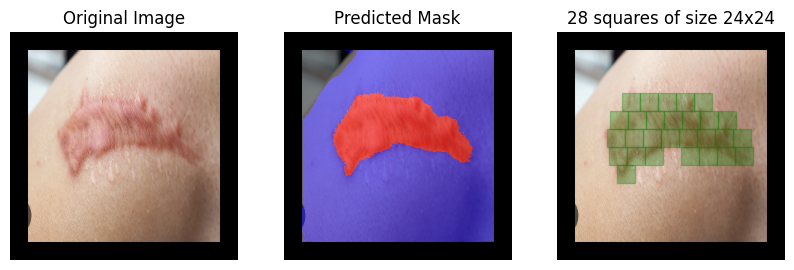

Found 28 squares in Hypertrophic01.png rotated by 0


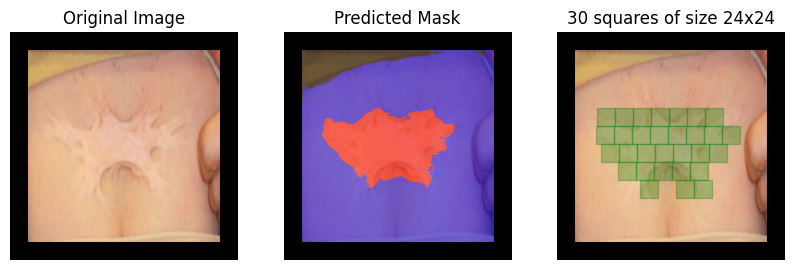

Found 30 squares in Hypertrophic02.png rotated by 0


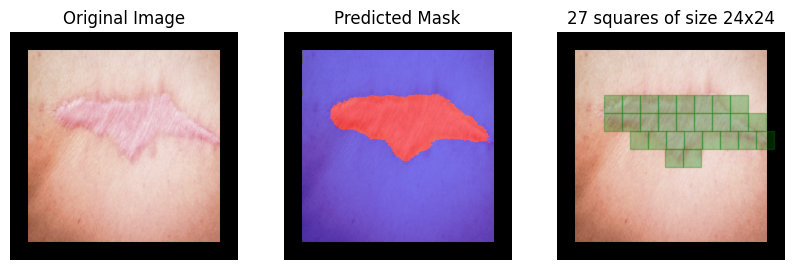

Found 27 squares in Hypertrophic03.png rotated by 0


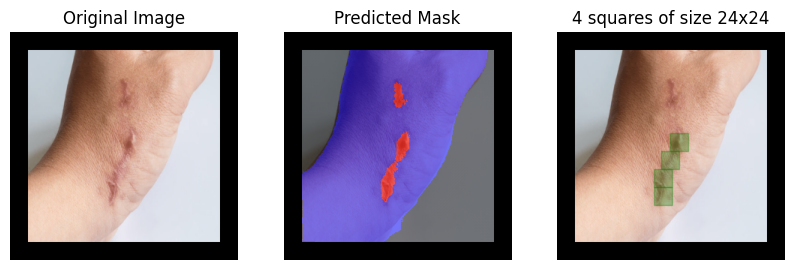

Found 4 squares in Hypertrophic04.png rotated by 0


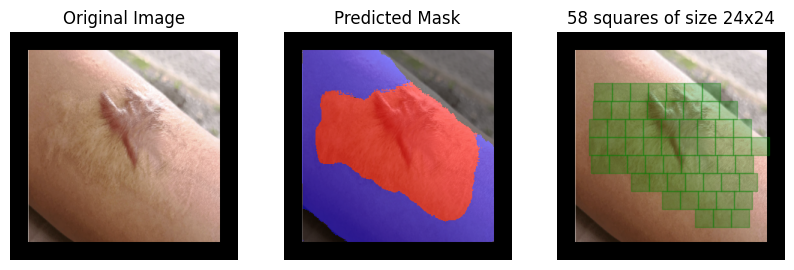

Found 58 squares in Hypertrophic05.png rotated by 0


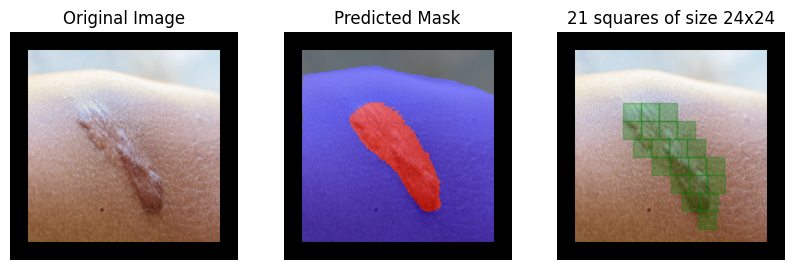

Found 21 squares in Hypertrophic06.png rotated by 0


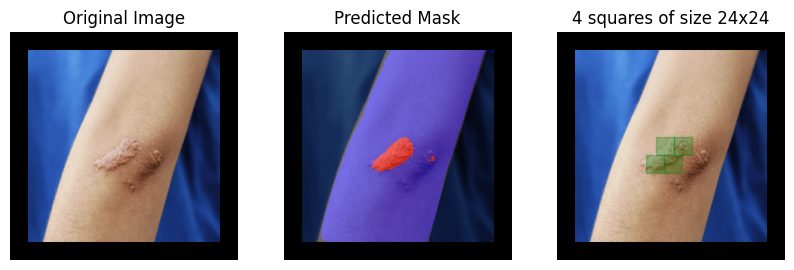

Found 4 squares in Hypertrophic07.png rotated by 0


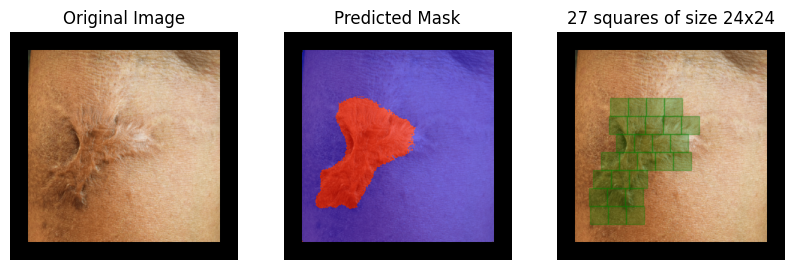

Found 27 squares in Hypertrophic08.png rotated by 0


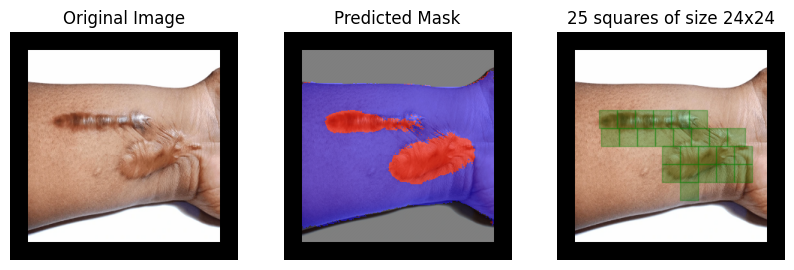

Found 25 squares in Hypertrophic09.png rotated by 0


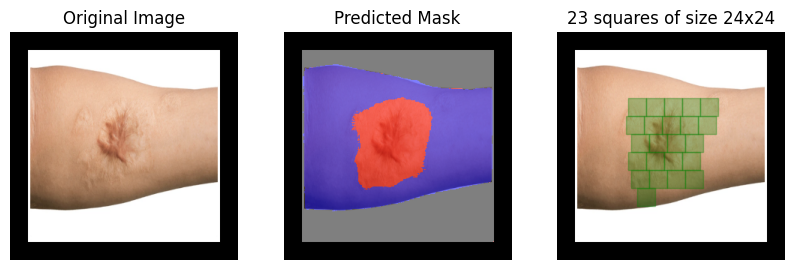

Found 23 squares in Hypertrophic10.png rotated by 0


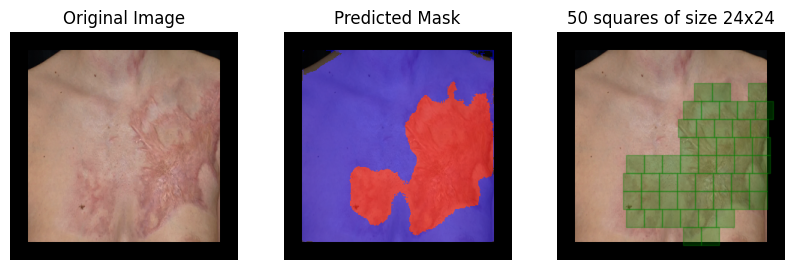

Found 50 squares in Hypertrophic11.png rotated by 0


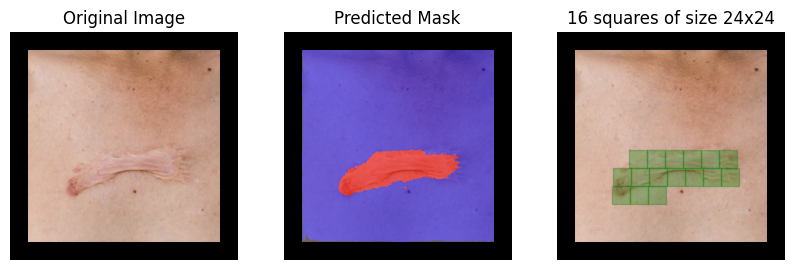

Found 16 squares in Hypertrophic12.png rotated by 0


In [14]:
#Visualizing get_squares
image_dir = "/content/Images"
image_names = [f"Hypertrophic{str(i).zfill(2)}.png" for i in range(1,13)]  # 00 to 11

for img_name in image_names:
  image_path = os.path.join(image_dir, img_name)
  # Call pipeline function
  squares, image_resized, rot_angle, clean_mask, pred_mask = get_squares(image_path, best_rotate = False, add_padding = True)

  # Plot the results
  fig, ax = plt.subplots(1, 3, figsize=(10,5))
  ax[0].imshow(image_resized)
  ax[0].set_title("Original Image")
  ax[0].axis("off")
  ax[1].imshow(overlay(image_resized/255.0, mask_to_rgb(pred_mask)))
  ax[1].set_title("Predicted Mask")
  ax[1].axis("off")
  _, _ = plot_square_cover(image_resized, squares, square_size=LASER_SIZE, opacity = 0.3, color = 'green', ax = ax[2])
  plt.axis("off")
  plt.show()
  print(f"Found {len(squares)} squares in {img_name} rotated by {rot_angle}")

Found 50 squares


(<Figure size 400x400 with 1 Axes>,
 <Axes: title={'center': '50 squares of size 24x24'}>)

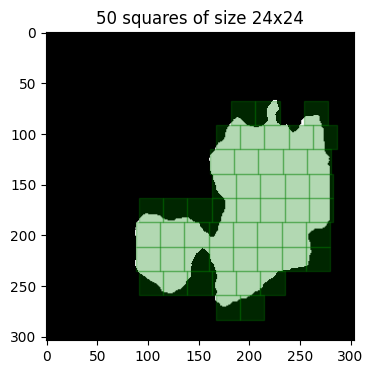

In [15]:
# Call the Image Processing pipeline
squares, image_resized, rot_angle, clean_mask, _ = get_squares("/content/Images/Hypertrophic11.png", add_padding = True)
print(f"Found {len(squares)} squares")
#plot the squares over the post-processed scar mask
plot_square_cover(clean_mask, squares, square_size=LASER_SIZE, opacity = 0.3)


## Heat Function and Visualization

### Temperature Math and Plotting functions

In [16]:
def temp_over_time(T_laser, time, scar_thickness):
  T_inf = 300 #Kelvin
  alpha = 22.5e-6 #m^2/s
  h = 2 #W/m^2*K Room Temp, Standard Pressure Air for free convection
  L_c = scar_thickness/2
  k = 0.3 #Currently assuming just skin and fat, could use something between 0.3 and 0.53 dependent on how much collagen is in the scar
  return T_inf+(T_laser-T_inf)*(np.exp((-alpha*h*time)/(k*L_c)))

def plot_laser_mask_cover(mask, laser_squares, individual_laser_squares, large_square_size=24, small_square_size=6, opacity=0.5, figsize=(4,4), show=True):
    """
    Make a plot of the squares over the mask. Squares are defined by their
    top-left corner and size.
    """
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(mask, cmap='gray', origin='upper')

    # Individual squares with temperature
    for ((r, c), temp, hit) in individual_laser_squares:
        color = temp_to_color(temp) if temp > 320 else 'green'
        edge = 'red' if hit else 'white'
        rect = plt.Rectangle((c, r), small_square_size, small_square_size, edgecolor=edge, facecolor=color, alpha=opacity)
        ax.add_patch(rect)

    # Large laser squares
    for (r, c) in laser_squares:
        rect = plt.Rectangle((c, r), large_square_size, large_square_size, edgecolor='blue', facecolor='none', alpha=opacity, linewidth=2)
        ax.add_patch(rect)

    if show:
        ax.set_title("LASER MASK")
        plt.show()
    else:
        return fig

def temp_to_color(temp, scale = 1):
    # Clamp range
    if temp <= 300:
        return (1.0*scale, 0.647*scale, 0.0)   # orange
    if temp >= 500:
        return (1.0*scale, 0.0, 0.0)     # red

    ratio = (temp - 300) / 200  # 200 = 500-300

    orange = (1.0, 0.647, 0.0)
    red    = (1.0, 0.0,   0.0)

    r = scale * (orange[0] + (red[0] - orange[0]) * ratio)
    g = scale * (orange[1] + (red[1] - orange[1]) * ratio)
    b = scale * (orange[2] + (red[2] - orange[2]) * ratio)

    return (r, g, b)

def draw_rect_border(img, r, c, size, color):
    """Draws a colored border around a square."""
    r2, c2 = r + size, c + size
    img[r:r+1, c:c2] = color        # top
    img[r2-1:r2, c:c2] = color      # bottom
    img[r:r2, c:c+1] = color        # left
    img[r:r2, c2-1:c2] = color      # right

def blend_square(region, color, alpha=0.3):
    """Blend a solid color rectangle over an image region."""
    overlay = np.zeros_like(region)
    overlay[:] = color
    return (region * (1 - alpha) + overlay * alpha).astype(np.uint8)

### Scar Section Classes

In [17]:
class TempSquare:
  """
  Individual laser-sized scar square with a temperature
  """
  def __init__(self, x, y):
      self.temp = 300
      self.hit_time = 0
      self.has_been_hit = False
      self.cornerx = x
      self.cornery = y
      self.temp_init = 300

  def hit(self, hit_t):
      # print("Square was lasered")
      self.temp_init = LASER_TEMP
      self.temp = temp_over_time(self.temp_init,0,SCAR_THICK)
      self.hit_time = hit_t
      self.has_been_hit = True


  def hit_near(self, near_time, new_temp):
      self.temp = temp_over_time(self.temp_init,near_time - self.hit_time,SCAR_THICK)
      # print(f"Square was near lasered with new temp: {new_temp} at {self.temp:.2f} with temp_init {self.temp_init:.2f}")
      if(near_time >= self.hit_time and self.temp < new_temp):
        self.temp = temp_over_time(new_temp,0,SCAR_THICK)
        self.temp_init = new_temp
        self.hit_time = near_time

  def find_temp(self, cur_time):
      #timedif = (self.hit_time-datetime.now()).total_seconds();
      if(not self.hit):
        print("Time is before hit/near time, not possible");
        return 0
      else:
        self.temp = temp_over_time(self.temp_init,(cur_time-self.hit_time),SCAR_THICK)
        return self.temp

  def cur_temp(self):
      return self.temp

  def get_corner(self):
      return (self.cornerx, self.cornery)

  def __str__(self):
      return f"Square at ({self.cornerx}, {self.cornery}) with temp {self.temp}"

In [18]:
class LaserSquare:
  """
  Laser-array-sized square of individual laser-sized squares (TempSquares)
  """
  def __init__(self, r, c):
      self.temp = 0
      self.hit_time = 0
      self.cornerx = r
      self.cornery = c
      self.temp_squares = []
      self.has_been_hit = False
      for i in range(3):
        for j in range(3):
          self.temp_squares.append(TempSquare(r+i*LASER_INDIVIDUAL_SIZE,c+j*LASER_INDIVIDUAL_SIZE))

  def add_square(self, square):
      self.temp_squares.append(square)

  def hit(self, hit_t):
      for square in self.temp_squares:
        square.hit(hit_t)
      self.has_been_hit = True

  def hit_above(self, near_time):
      i = 0
      for square in self.temp_squares:
        if i < 3:
          new_temp = (LASER_TEMP-300)/3 + 300
          square.hit_near(near_time, new_temp)
        elif i < 6:
          new_temp = (LASER_TEMP-300)/4 + 300
          square.hit_near(near_time, new_temp)
        else:
          new_temp = (LASER_TEMP-300)/5 + 300
          square.hit_near(near_time, new_temp)
        i += 1

  def hit_below(self, near_time):
    i = 0
    for square in self.temp_squares:
      if i < 3:
        new_temp = (LASER_TEMP-300)/5 + 300
        square.hit_near(near_time, new_temp)
      elif i < 6:
        new_temp = (LASER_TEMP-300)/4 + 300
        square.hit_near(near_time, new_temp)
      elif i < 9:
        new_temp = (LASER_TEMP-300)/3 + 300
        square.hit_near(near_time, new_temp)
      i += 1

  def hit_left(self, near_time):
    i = 0
    for square in self.temp_squares:
      if i%3 == 0:
        new_temp = (LASER_TEMP-300)/3 + 300
        square.hit_near(near_time, new_temp)
      elif i%3 == 1:
        new_temp = (LASER_TEMP-300)/4 + 300
        square.hit_near(near_time, new_temp)
      elif i%3 == 2:
        new_temp = (LASER_TEMP-300)/5 + 300
        square.hit_near(near_time, new_temp)
      i += 1

  def hit_right(self, near_time):
    i = 0
    for square in self.temp_squares:
      if i%3 == 0:
        new_temp = (LASER_TEMP-300)/5 + 300
        square.hit_near(near_time, new_temp)
      elif i%3 == 1:
        new_temp = (LASER_TEMP-300)/4 + 300
        square.hit_near(near_time, new_temp)
      elif i%3 == 2:
        new_temp = (LASER_TEMP-300)/3 + 300
        square.hit_near(near_time, new_temp)
      i += 1

  def find_temp(self, cur_time):
      for square in self.temp_squares:
        square.find_temp(cur_time)

  def get_individual_lasers(self):
      return self.temp_squares

  def get_individual_corners_colors(self):
    individual_laser_corners = []
    for individual_laser in self.temp_squares:
          individual_laser_corners.append([individual_laser.get_corner(), individual_laser.cur_temp(), self.been_hit()])
    return individual_laser_corners

  def get_corner(self):
      return (self.cornerx, self.cornery)

  def max_temp(self):
    max_temp = 0
    for square in self.temp_squares:
      if square.cur_temp() > max_temp:
        max_temp = square.cur_temp()
    return max_temp

  def __str__(self):
    square_str = ""
    i = 0
    for square in self.temp_squares:
      if i % 3 == 0:
        square_str += "\n"
      square_str += f"{square.cur_temp():.2f} "
      i += 1
    return square_str

  def copy(self):
    return LaserSquare(self.cornerx, self.cornery)

  def been_hit(self):
    return self.has_been_hit

In [19]:
class ScarSquareMask:
  """
  Entire scar mask of laser-array-sized squares (LaserSquares)
  """
  def __init__(self, squares):
      self.laser_square_grid = []
      self.laser_squares = []
      for square in squares:
        self.laser_squares.append(LaserSquare(square[0],square[1]))

  def hit_laser(self, laser_index, hit_t, autoupdate = True):
      target = self.laser_squares[laser_index]
      target.hit(hit_t)
      target_r = target.cornerx
      target_c = target.cornery
      #find adjacent squares
      adjacent_squares = self.find_adjacent_squares(laser_index)
      for adj_idx in adjacent_squares:
        c = self.laser_squares[adj_idx].cornery
        r = self.laser_squares[adj_idx].cornerx
        if r > target_r:
          #hit near the top of squares below
          self.laser_squares[adj_idx].hit_above(hit_t)
        elif r < target_r:
          #hit near the bottom of square above
          self.laser_squares[adj_idx].hit_below(hit_t)
        elif c > target_c:
          #hit near the left of squares to the right
          self.laser_squares[adj_idx].hit_left(hit_t)
        else:
          #hit near the right of squares to the left
          self.laser_squares[adj_idx].hit_right(hit_t)
      #autoupdate all other squares
      for laser in self.laser_squares:
        laser.find_temp(hit_t)

  def find_temp(self, cur_time):
      for laser in self.laser_squares:
        laser.find_temp(cur_time)

  def get_individual_lasers(self):
      individual_lasers = []
      for laser in self.laser_squares:
        for square in laser.get_individual_lasers():
          individual_lasers.append(square)
      return individual_lasers

  def get_individual_corners_colors(self):
    individual_laser_corners = []
    for laser in self.laser_squares:
      for square in laser.get_individual_corners_colors():
        individual_laser_corners.append(square)
    return individual_laser_corners

  def get_laser_corners(self):
    laser_corners = []
    for laser in self.laser_squares:
      laser_corners.append(laser.get_corner())
    return laser_corners

  def find_adjacent_squares(self, laser_index):
    adjacent_squares = []
    laser = self.laser_squares[laser_index]
    r = laser.cornerx
    c = laser.cornery
    for i, corner in enumerate(self.get_laser_corners()):
      # if corner is within a square + 1 if the corner, add the index to the list
      if abs(corner[0] - r) <= LASER_SIZE+1 and abs(corner[1] - c) <= LASER_SIZE+1:
        if i != laser_index:
          adjacent_squares.append(i)
    return adjacent_squares

  def get_number_hit(self):
    total_hit = 0
    for laser in self.laser_squares:
      if laser.has_been_hit:
        total_hit += 1
    return total_hit

  def __str__(self):
    square_str = f"laser grid of size {len(self.laser_squares)} laser blocks \n"
    return square_str

  def copy(self):
    new_laser_corners = self.get_laser_corners()
    return ScarSquareMask(new_laser_corners)

  def has_laser_hit(self, laser_index):
    target = self.laser_squares[laser_index]
    return target.been_hit()

  def plot_the_grid(self, mask, show = True):
    individual_laser_corners = self.get_individual_corners_colors()
    fig = plot_laser_mask_cover(mask, self.get_laser_corners(), individual_laser_corners, large_square_size = LASER_SIZE, small_square_size=LASER_INDIVIDUAL_SIZE, opacity = 0.3, show = show)
    return fig

### Using the ScarSquareMask Class to Represent a Segmented Scar

In [20]:
squares, image_resized, rot_angle, clean_mask, _ = get_squares("/content/Images/Hypertrophic11.png", add_padding = True)
scar_grid = squares
laser_grid = ScarSquareMask(scar_grid)
print(laser_grid)

laser grid of size 50 laser blocks 



## Beginning Reinforcement learning

### Initial Setup of a Scar Square Mask

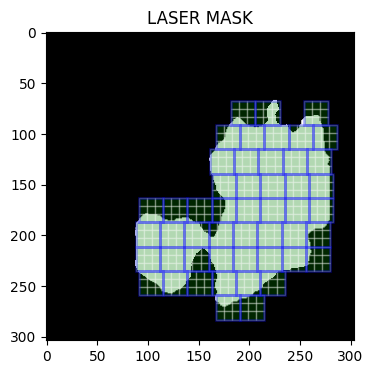

In [21]:
#SETUP
start_laser_grid = ScarSquareMask(scar_grid)
# plot the squares on the scar's post-processed mask
start_laser_grid.plot_the_grid(clean_mask)
#goal is 100% completion
goal = len(scar_grid)

### Defining Reinforcement Learning Parameters and Reward Values

In [40]:
#define RL parameters
num_episodes = 8000
alpha = 0.1
gamma = 0.9
global epsilon
epsilon = 0.475

reward_burn = -50
reward_per_square_hit = 10
reward_find_new_square = 45
reward_goal = 1000
reward_close = -20

actions = range(len(scar_grid))

Q = np.zeros((len(scar_grid)+1,(len(actions))))
print(Q.shape)

(51, 50)


### Functions Needed to Determine Reinforcement Learning Rewards

In [41]:
#functions
def is_major_burn(idx, laser_grid):
  """
  if we laser something with temp > 375, we burn the patient
  """
  return laser_grid.laser_squares[idx].max_temp() > 375

def is_minor_burn(idx, laser_grid):
  """
  if we laser something with temp > 325, we burn the patient
  """
  return laser_grid.laser_squares[idx].max_temp() > 325

def is_new(idx, laser_grid):
  """
  if we laser something that has not been hit before
  """
  return not laser_grid.laser_squares[idx].been_hit();

def choose_action(state):
    if np.random.random() < epsilon:
        return np.random.randint(len(actions))
    else:
        return np.argmax(Q[state])

def how_close(action, previous_action):
  corners1 = start_laser_grid.laser_squares[action].get_corner()
  corners2 = start_laser_grid.laser_squares[previous_action].get_corner()
  distance1 = np.sqrt((corners1[0] - corners2[0])**2 + (corners1[1] - corners2[1])**2)
  corners3 = start_laser_grid.laser_squares[0].get_corner()
  corners4 = start_laser_grid.laser_squares[len(actions) -1].get_corner()
  maxdistance = np.sqrt((corners3[0] - corners4[0])**2 + (corners3[1] - corners4[1])**2)
  return (distance1/maxdistance)

### Reinforcement Learning Training Loop

In [42]:
# rewards and training
rewards_all_episodes = []

for episode in range(num_episodes):
    state = 0
    total_rewards = 0
    done = False
    prev_action = 0
    time = 0

    while not done:
        time = time + 20
        if state != 0:
          prev_action = action

        action_index = choose_action(state)
        action = actions[action_index]
        if is_major_burn(action, start_laser_grid):
            reward = reward_burn
            #print("Major Burn")
            done = True
            del start_laser_grid
            start_laser_grid = ScarSquareMask(scar_grid)
        else:
            if is_minor_burn(action, start_laser_grid):
              minor_burn_penalty = -15
            else:
              minor_burn_penalty = 10
            if is_new(action, start_laser_grid):
              reward = reward_find_new_square + reward_close*how_close(action, prev_action) + minor_burn_penalty
            start_laser_grid.hit_laser(action, time)
            next_state = start_laser_grid.get_number_hit()
            if next_state == goal:
                #print(f"next state: {next_state} goal: {goal} at episode {episode}")
                reward = reward_goal
                done = True
                del start_laser_grid
                start_laser_grid = ScarSquareMask(scar_grid)
            #else:
                #print(f"Achieved: {next_state} Goal: {goal} at episode {episode}")
                #reward = reward_per_square_hit * (next_state)

        old_value = Q[state][action_index]
        next_max = np.max(Q[next_state]) if not is_major_burn(action, start_laser_grid) else 0

        Q[state][action_index] = old_value + alpha*(reward + gamma * next_max - old_value)

        state = next_state
        total_rewards += reward

    epsilon = max(0.01, epsilon * 0.975)
    rewards_all_episodes.append(total_rewards)
    if episode % 500 == 0:
        print(f"Episode: {episode} of {num_episodes}, Total Reward: {total_rewards}")
    # print(f"Episode: {episode}, Total Reward: {total_rewards}")

Episode: 0 of 8000, Total Reward: 173.58788956026643
Episode: 500 of 8000, Total Reward: 1711.9296179322967
Episode: 1000 of 8000, Total Reward: 1495.4394983948494
Episode: 1500 of 8000, Total Reward: 3085.3271006951763
Episode: 2000 of 8000, Total Reward: 3041.7552201130047
Episode: 2500 of 8000, Total Reward: 3041.7552201130047
Episode: 3000 of 8000, Total Reward: 3041.7552201130047
Episode: 3500 of 8000, Total Reward: 1314.232638799753
Episode: 4000 of 8000, Total Reward: 124.18778044918804
Episode: 4500 of 8000, Total Reward: 708.7323539562868
Episode: 5000 of 8000, Total Reward: 3041.7552201130047
Episode: 5500 of 8000, Total Reward: 1903.1588546810397
Episode: 6000 of 8000, Total Reward: 3041.7552201130047
Episode: 6500 of 8000, Total Reward: 3041.7552201130047
Episode: 7000 of 8000, Total Reward: 1744.5390522312002
Episode: 7500 of 8000, Total Reward: 3041.7552201130047


#### Visualizing Reinforcement Rewards During Training

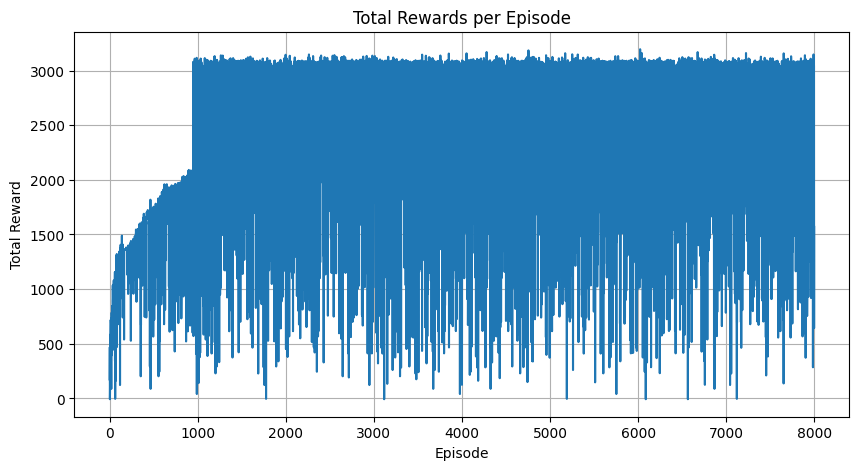

In [43]:
def plot_rewards(rewards):
    plt.figure(figsize=(10, 5))
    plt.plot(rewards)
    plt.title('Total Rewards per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True)
    plt.show()

plot_rewards(rewards_all_episodes)

### Using Model Trained with Reinforcement Learning to Find Optimal Path Through Laser Squares

In [45]:
# Finding optimal path
def get_optimal_path(Q, goal, actions, scar_overlay, max_steps=len(actions)):
    path = []
    state = scar_overlay.get_number_hit()

    for step in range(max_steps):
        if state == goal:
            break

        best_action = None
        best_value = -float('inf')

        for idx, action in enumerate(actions):
            new_laser_grid = scar_overlay.copy()
            new_laser_grid.hit_laser(action, step*10)

            next_state = new_laser_grid.get_number_hit()

            if Q[state][idx] > best_value:
                best_value = Q[state][idx]
                best_action = idx
                # print(f"Best action is {best_action}")
            #throw out new_laser_grid
            del new_laser_grid

        if best_action is None:
            break

        move = actions[best_action]
        scar_overlay.hit_laser(move, step*10)
        state = scar_overlay.get_number_hit()
        path.append(actions[best_action])

    return path

pathing_laser_grid = ScarSquareMask(scar_grid)
optimal_path = get_optimal_path(Q, goal, actions, pathing_laser_grid, max_steps=(len(actions)))
print(optimal_path)
new_path = optimal_path
new_path.sort()
print(new_path)
print(len(new_path))
print(len(actions))

[12, 30, 48, 5, 0, 1, 33, 47, 19, 2, 24, 10, 8, 20, 35, 9, 25, 3, 38, 44, 26, 21, 28, 15, 4, 36, 6, 45, 13, 7, 11, 29, 14, 16, 17, 18, 22, 23, 27, 31, 32, 34, 42, 37, 39, 40, 41, 43, 46, 49]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
50
50


### Visualizing the Reinforcement Learning Path

Laser order: [12, 30, 48, 5, 0, 1, 33, 47, 19, 2, 24, 10, 8, 20, 35, 9, 25, 3, 38, 44, 26, 21, 28, 15, 4, 36, 6, 45, 13, 7, 11, 29, 14, 16, 17, 18, 22, 23, 27, 31, 32, 34, 42, 37, 39, 40, 41, 43, 46, 49]


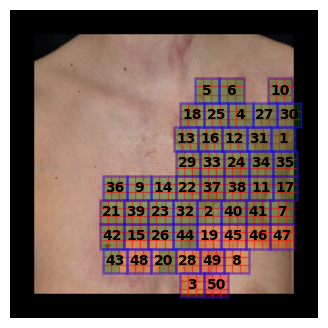

In [46]:
def plot_moves_labeled(moves, background):
    temp_laser_grid = ScarSquareMask(scar_grid)
    time = 0
    visited = []  # list of (r, c) in move order

    # Apply moves and record locations
    for move in moves:
        temp_laser_grid.hit_laser(move, time)
        r, c = temp_laser_grid.laser_squares[move].get_corner()
        visited.append((r, c))
        time += 15

    print("Laser order:", [int(i) for i in moves])

    fig = temp_laser_grid.plot_the_grid(background, show=False)
    ax = fig.axes[0]

    # Label each box with move order
    for idx, (r, c) in enumerate(visited, start=1):
        ax.text(
            c + LASER_SIZE/2,
            r + LASER_SIZE/2,
            str(idx),
            ha="center",
            va="center",
            fontsize=10,
            color="Black",
            weight="bold"
        )

    del temp_laser_grid
    return fig
pathing_laser_grid = ScarSquareMask(scar_grid)
new_optimal_path = get_optimal_path(Q, goal, actions, pathing_laser_grid, max_steps=(len(actions)))
background = image_resized
plot_moves_labeled(new_optimal_path, background)
plt.axis('off')
plt.show()

#### Code for Making a GIF

In [52]:
def generate_frames(new_optimal_path):
  temp_laser_grid = ScarSquareMask(scar_grid)
  time = 0
  frames = []
  for move in new_optimal_path:
      temp_laser_grid.hit_laser(move, time)
      time += 2.5

      # Draw the grid
      fig = temp_laser_grid.plot_the_grid(background, show=False)

      # Render the figure
      fig.canvas.draw()

      # Convert plot to numpy array
      buf = fig.canvas.buffer_rgba()
      frame = np.asarray(buf)[:, :, :3]   # ignore alpha
      frames.append(frame)
      plt.close(fig)  # close figure instead of showing it

      for i in range(6):
          temp_laser_grid.find_temp(time)
          fig = temp_laser_grid.plot_the_grid(background, show=False)
          fig.canvas.draw()
          buf = fig.canvas.buffer_rgba()
          frame = np.asarray(buf)[:, :, :3]   # ignore alpha
          frames.append(frame)
          plt.close(fig)  # close figure instead of showing it
          time += 2.5

  return frames

# Save all frames as GIF
frames = generate_frames(new_optimal_path)
gif_name = "laser_sim_RL_slowFR.gif"
imageio.mimsave(gif_name, frames, fps=5)
print("Saved as", gif_name)

Saved as laser_sim_RL_slowFR.gif


## Greedy algorithm baseline

In [51]:
# --- Parameters ---
coords = np.array([])
for square in scar_grid:
    square = np.array([square[1], square[0]])
    coords = np.append(coords, square)
coords = coords.reshape(-1, 2)
heat_effect_radius = LASER_SIZE * 1.5 #at least one square diagonal away
cooldown = 98.37 #time it takes for an adjacent laser square to cool down so that it won't be burned if lasered
step_time = 0.2  # time per step
step_size = 1    # move 1 unit per step

# --- Initialize states ---
n = len(coords)
lasered = np.zeros(n, dtype=bool)
last_lasered = -np.inf * np.ones(n)
time = 0
pos = np.array([0,0])
states = np.zeros(n)
order = []

# Manhattan Distance
def distance(p1, p2):
    return np.abs(p1[0]-p2[0]) + np.abs(p1[1]-p2[1])

# Find the closest scar box that can be lasered
def next_target():
    #find when each scar box is "ready" to be lasered
    ready_times = np.maximum(time, last_lasered + cooldown)
    #calculate the travel time it would take to get to each scar square from the current agent position
    travel_times = np.array([distance(pos, coords[i])*step_time if not lasered[i] else np.inf for i in range(n)])
    #add the two times and see which is the minimum to find the next scar square to laser
    total_times = ready_times + travel_times
    return np.argmin(total_times)

# Lasering loop
while not all(lasered):
    idx = next_target()
    target = coords[idx].copy()

    # Move step by step (Manhattan path)
    while not np.array_equal(pos, target):
        # Determine step in x
        if pos[0] < target[0]:
            pos[0] += step_size
        elif pos[0] > target[0]:
            pos[0] -= step_size
        # Determine step in y
        elif pos[1] < target[1]:
            pos[1] += step_size
        elif pos[1] > target[1]:
            pos[1] -= step_size

        time += step_time

        # Update warm/cool states
        states = np.zeros(n)
        for i in range(n):
            if (not last_lasered[i] == -1) and time - last_lasered[i] < cooldown:
                states[i] = 1  # warm
            elif last_lasered[i] == -1:
                states[i] = 2  # already hit

    # Laser the target
    lasered[idx] = True
    last_lasered[idx] = -1
    order.append(idx)

    # Update coordinates affected by laser radius
    for i, c in enumerate(coords):
        if not lasered[i]:
            if np.linalg.norm(pos - c) <= heat_effect_radius:
                last_lasered[i] = time

#print the order as ints
print("Laser order:", [int(i) for i in order])

# Save all frames as GIF
frames = generate_frames(new_optimal_path)
gif_name = "greedy_slowFR.gif"
imageio.mimsave(gif_name, frames, fps=5)
print("Saved as", gif_name)

Laser order: [0, 9, 11, 24, 22, 20, 18, 34, 36, 38, 40, 49, 4, 6, 16, 14, 30, 28, 26, 42, 44, 46, 32, 25, 12, 2, 1, 10, 8, 21, 19, 35, 37, 39, 41, 17, 7, 5, 15, 13, 3, 48, 47, 31, 29, 27, 43, 33, 45, 23]
Saved as laser_sim_RL_slowFR.gif


## Comparing Reinforcement Learning and Greedy Algorithms

### Path Visualization

Laser order: [0, 9, 11, 24, 22, 20, 18, 34, 36, 38, 40, 49, 4, 6, 16, 14, 30, 28, 26, 42, 44, 46, 32, 25, 12, 2, 1, 10, 8, 21, 19, 35, 37, 39, 41, 17, 7, 5, 15, 13, 3, 48, 47, 31, 29, 27, 43, 33, 45, 23]


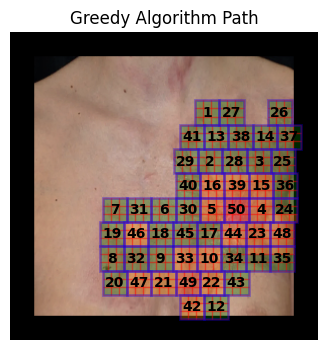

Laser order: [12, 30, 48, 5, 0, 1, 33, 47, 19, 2, 24, 10, 8, 20, 35, 9, 25, 3, 38, 44, 26, 21, 28, 15, 4, 36, 6, 45, 13, 7, 11, 29, 14, 16, 17, 18, 22, 23, 27, 31, 32, 34, 42, 37, 39, 40, 41, 43, 46, 49]


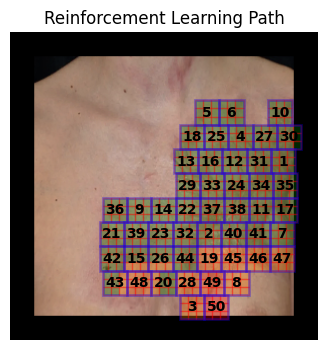

In [48]:
greedy_fig = plot_moves_labeled(order, background)
plt.axis('off')
plt.title("Greedy Algorithm Path")
plt.show()

rl_fig = plot_moves_labeled(new_optimal_path, background)
plt.axis('off')
plt.title("Reinforcement Learning Path")
plt.show()


### Quantitative Path Metrics

In [49]:
def find_distance_traveled(new_laser_grid, moves):
  distance_traveled = 0
  prev_move = moves[0]
  for move in moves[1:]:
    p1 = new_laser_grid.laser_squares[prev_move].get_corner()
    p2 = new_laser_grid.laser_squares[move].get_corner()
    distance_between = distance(p1, p2)
    distance_traveled += distance_between
    prev_move = move
  return distance_traveled

def get_number_of_burns(moves, timestep = 20, scar_grid = scar_grid):
  temp_laser_grid = ScarSquareMask(scar_grid)
  number_of_large_burns = 0
  number_of_small_burns = 0
  time = 0
  for move in moves:
    time += timestep
    if is_major_burn(move, temp_laser_grid):
      number_of_large_burns += 1
    if is_minor_burn(move, temp_laser_grid):
      number_of_small_burns += 1
    temp_laser_grid.hit_laser(move, time)
  del temp_laser_grid
  return number_of_large_burns, number_of_small_burns

move_timestep = 20
print(f"{'Metric':<40} {'Value'}")
print("-" * 60)
# print(f"{'Optimal path':<30} {new_optimal_path}")
# print(f"{'Original order':<30} {[int(i) for i in order]}")
print(f"{'Distance Traveled (reinforcement)':<40} {find_distance_traveled(new_laser_grid, new_optimal_path)}")
print(f"{'Distance Traveled (greedy)':<40} {find_distance_traveled(new_laser_grid, order)}")
print(f"{'Burns Major and Minor (reinforcement)':<40} {get_number_of_burns(new_optimal_path, move_timestep)}")
print(f"{'Burns Major and Minor (greedy)':<40} {get_number_of_burns(order, move_timestep)}")



Metric                                   Value
------------------------------------------------------------
Distance Traveled (reinforcement)        5092
Distance Traveled (greedy)               3083
Burns Major and Minor (reinforcement)    (0, 10)
Burns Major and Minor (greedy)           (0, 0)
